<a href="https://colab.research.google.com/github/behzadzh/Python-Tutorials/blob/master/Copy_of_Day_8_of_8_Building_Basic_Agentic_RAG_Systems_(Self_Route_Agentic_RAG_System)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Day 8: Building a Self-Route Agentic RAG System**

Welcome to Day 8 of our series on building advanced RAG systems! Today, we’re diving into a powerful optimization technique known as **Self-Route Agentic RAG**. This method leverages the reasoning abilities of Large Language Models (LLMs) to dynamically decide the best way to process a user query: using standard RAG or routing to a long-context model. This approach not only enhances accuracy but also optimizes for cost and efficiency.

**What is Self-Route Agentic RAG?**

Traditional RAG systems retrieve information and feed it to an LLM to answer a user’s question. In contrast, Self-Route Agentic RAG introduces a decision-making layer. The LLM itself assesses whether the initially retrieved context is sufficient to answer the query. If the LLM judges the context to be lacking, the query is routed to a long-context model with an enriched or expanded set of documents. This sophisticated process effectively mirrors how a human expert might approach a research question – assessing what's known before diving into deeper investigation.

**Benefits of Self-Route Agentic RAG:**

*   **Improved Accuracy:** By using long-context models only when necessary, the system provides more comprehensive answers for complex queries.
*   **Cost-Efficiency:** Standard RAG workflows are used for simpler queries, saving on the computational cost of long-context models.
*   **Dynamic Adaptation:** The system can dynamically adapt to input complexity by utilizing LLM reflection to make routing decisions.
*   **Reduced Hallucination:** Prompts are used that explicitly instruct the LLM to strictly use information from the context provided which reduces hallucination.

**How It Works: Key Components**

Let's break down the architecture and key steps of a Self-Route Agentic RAG system:

1.  **Standard RAG Flow:**
    *   **Input Query and Context Retrieval:** A user submits a query, and the system retrieves relevant documents from a Vector Database.
    *   **Decision Node:** An LLM (e.g., GPT-4o) receives the query and the retrieved context. The Decision Node LLM uses a prompt to self-reflect and determine if the retrieved context is sufficient to answer the query accurately.
    *   **LLM Judge Prompt:**
        ```
        Write UNANSWERABLE if the query cannot be answered based on the provided context else write ANSWERABLE.
        Query: <query>
        Context Doc: <context>
        ```
    *   **Routing:**
        *   If the response from the LLM is "ANSWERABLE", proceed with the Standard RAG Prompt.
        *   If the response from the LLM is "UNANSWERABLE", proceed with the Long-Context LLM Flow.
    *   **RAG Prompt (for ANSWERABLE queries):**
        ```
        Given a query and context documents, use only the provided information to answer the query, do not make up answers.
        Query: <query>
        Context: <context>
        ```
    *   **Answer Generation:** The LLM processes the RAG prompt and generates an answer.

2.  **Long-Context LLM Flow:**
    *   **Trigger Condition:** This flow is activated when the Decision Node LLM deems the initial context to be insufficient.
    *   **Merging Context Documents:** Multiple related context documents are merged into a single long-context document for better context continuity.
    *   **Long Context Prompt:**
        ```
        Given a query and this context document, use only the provided information to answer the query, do not make up answers.
        Query: <query>
        Context: <long_context>
        ```
    *   **Answer Generation:** The LLM processes the Long Context prompt and generates an answer based on the long, merged context.

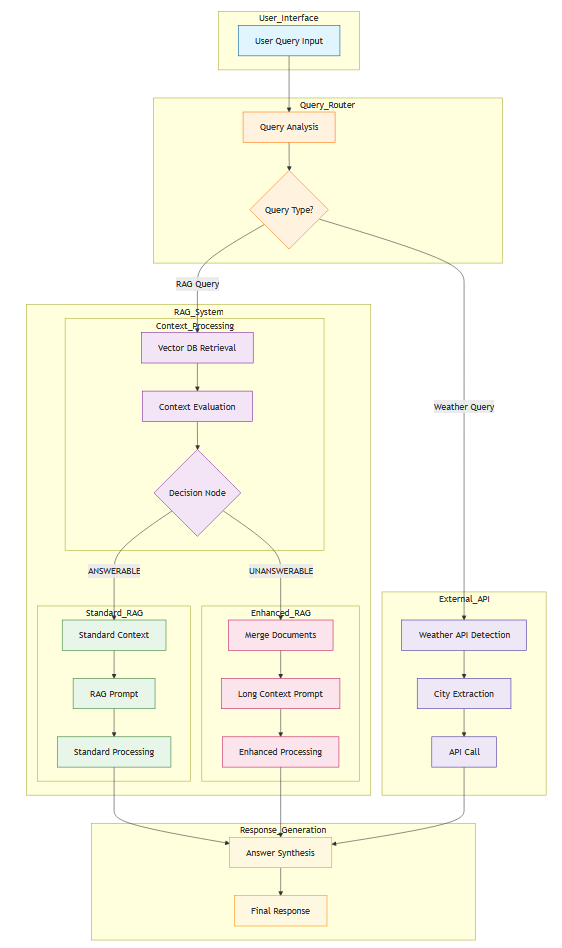

**Hands-On Tutorial: Building Your Self-Route Agentic RAG System (Google Colab Notebook)**

Now, let's implement this architecture. We will be using Google Colab, making it easy for you to follow along and replicate the results.

**1. Setup and Installation:**

In [ ]:
# Install necessary libraries
!pip install openai langchain chromadb tiktoken gradio requests python-dotenv langchain_experimental langchain_community

In [ ]:
import os
import openai
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv
import gradio as gr
import requests
import re
import openai
from google.colab import userdata

In [ ]:
load_dotenv()

# Initialize OpenAI API key
# openai.api_key = os.getenv("OPENAI_API_KEY")
OPENAI_API_KEY = userdata.get('openai')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

# Setting the GPT model
MODEL_NAME = "gpt-4o" # can also use gpt-4-1106-preview

**2. Data Preparation & Vector Database Setup**

In this example we'll be working with example text, however, you can swap this out for your own documents. The goal here is to establish a knowledge base which we will use to construct our RAG system.

In [ ]:
# Sample Data for demonstration
documents = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is revolutionizing many industries.",
    "Quantum computing has the potential to solve problems intractable for classical computers.",
    "Climate change is one of the most pressing issues facing humanity today.",
    "The history of art is as old as human history itself and art has been an expression of human values and beliefs throughout the ages",
    "The economic impact of the tech boom is changing the geopolitical landscape.",
    "The study of genetics has unlocked many of the secrets of heredity and disease.",
    "Sustainable development is essential for a healthy future.",
    "Deep learning models require large amounts of training data to achieve accurate predictions.",
    "The effects of social media on youth is a popular topic of debate in the age of the internet.",
    "The discovery of DNA completely changed the scientific world and was a huge breakthrough in our understanding of genetics."
]

# Convert texts to LangChain Documents
docs = [Document(page_content=doc) for doc in documents]

# Chunk the data
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(docs)

# Embed and Store in ChromaDB
embeddings = OpenAIEmbeddings()
persist_directory = 'chroma_db'  # For persistence purposes, use a directory
vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=persist_directory)
vectordb.persist() #persist the database for later usage

# Load persisted database for future use
# vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings) # For loading previously persisted vector db

**3. Core Functions:**

We'll create the following core functions:
*  **`retrieve_context(query, k=3)`**: Function to retrieve context documents from the vector database.
*   **`decision_node(query, context)`**: Function that evaluates the context using LLM.
*   **`standard_rag(query, context)`**: Function for generating answer using RAG Prompt.
*   **`long_context_rag(query, context_documents)`**: Function for generating an answer using long-context LLM flow.
*   **`self_route_agentic_rag(query)`**:  The core function integrating all parts of the system.

In [ ]:
# Function to retrieve context
def retrieve_context(query, k=3):
    retriever = vectordb.as_retriever(search_kwargs={"k": k})
    context_docs = retriever.get_relevant_documents(query)
    context_text = [doc.page_content for doc in context_docs]  # Extract text
    return context_text, context_docs

# Function for the Decision Node
def decision_node(query, context):
    prompt_template = """Write UNANSWERABLE if the query cannot be answered based on the provided context else write ANSWERABLE.
    Query: {query}
    Context Doc: {context}
    """
    prompt = PromptTemplate(template=prompt_template, input_variables=["query", "context"])
    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)
    chain = prompt | llm
    response = chain.invoke({"query":query, "context": str(context)})
    return response.content

# Function for standard RAG
def standard_rag(query, context):
     prompt_template = """Given a query and context documents, use only the provided information to answer the query, do not make up answers.
    Query: {query}
    Context: {context}
    """
     prompt = PromptTemplate(template=prompt_template, input_variables=["query", "context"])
     llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)
     chain = prompt | llm
     response = chain.invoke({"query": query, "context": str(context)})
     return response.content

# Function for long-context LLM flow
def long_context_rag(query, context_documents):
    merged_context = " ".join([doc.page_content for doc in context_documents])
    prompt_template = """Given a query and this context document, use only the provided information to answer the query, do not makeup answers.
    Query: {query}
    Context: {long_context}
    """
    prompt = PromptTemplate(template=prompt_template, input_variables=["query", "long_context"])
    llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)
    chain = prompt | llm
    response = chain.invoke({"query": query, "long_context": merged_context})
    return response.content


# Function to fetch real-time weather data
def get_realtime_weather(city):
    api_key = userdata.get("OPENWEATHER_API_KEY")
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    url = f"{base_url}appid={api_key}&q={city}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()
        weather_description = data['weather'][0]['description']
        temperature_kelvin = data['main']['temp']
        temperature_celsius = temperature_kelvin - 273.15
        return f"The weather in {city} is {weather_description} with a temperature of {temperature_celsius:.2f} degrees Celsius."
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
           return f"Could not find weather data for '{city}'. Please check the city name."
        else:
             return f"Could not retrieve weather data: {e}"
    except requests.exceptions.RequestException as e:
        return f"Could not retrieve weather data: {e}"

# Modified Self-Route RAG for Real-Time API
def self_route_rag_with_weather(query):
    # Check if query is related to weather
    routing_decision = ""  # Initialize routing decision variable
    if "weather" in query.lower():
        # Attempt to extract city from query using more robust logic
        city_parts = query.lower().split("weather in") # Split on "weather in"
        if len(city_parts) > 1: # Ensure "weather in" is present
            city = city_parts[1].strip() #Extract the string following "weather in"
            city = re.sub(r'^(the|city|of)\s+', '', city).strip() #Remove the and city of
            city = city.split(" ")[0].strip("?.") # Take first word as city name
        elif "weather in" not in query.lower(): #Checks if "weather in" isn't in the query
            city_parts = query.lower().split("weather") # Splits on weather if "weather in" is not present
            if len(city_parts) > 1:
                city = city_parts[1].strip() #Extract string following "weather"
                city = re.sub(r'^(the|city|of)\s+', '', city).strip() #Remove the and city of
                city = city.split(" ")[0].strip("?.") #Take the first word as the city name
            else:
                return "Please provide a city for weather information.", ""  # Return empty routing decision

        else:
            return "Please provide a city for weather information.", ""  # Return empty routing decision

        if city:
            weather_info = get_realtime_weather(city)
            routing_decision = "Self Route RAG to get Realtime Weather"
            return weather_info, routing_decision  # Return weather info and routing decision
        else:
            return "Please provide a city for weather information.", ""  # Return empty routing decision

    else: # Proceed with original RAG if its not a weather query
        # Retrieve context
        context_text, context_docs = retrieve_context(query)
        # Decision node
        decision = decision_node(query, context_text)

        # Route based on decision
        if "ANSWERABLE" in decision:
            # print("Answerable - Standard RAG")
            response = standard_rag(query, context_text)
            routing_decision = "Standard RAG - Direct Answer from Knowledge Base"
        else:
            # print("Not Answerable - Long Context RAG")
            response = long_context_rag(query, context_docs)
            routing_decision = "Long Context RAG - Answer Requires More Context"

        return response, routing_decision  # Return response and routing decision

**4. Integrate with Gradio for User Interface**

In [ ]:
iface = gr.Interface(
    fn=self_route_rag_with_weather,
    inputs=gr.Textbox(label="Enter your query"),
    outputs=[
        gr.Textbox(label="Response"),
        gr.Textbox(label="Routing Decision")
    ],
    title="Self-Route Agentic RAG with Real-Time Weather Demo",
    description="Ask questions and test the Self-Route Agentic RAG System or get real time weather data!"
)

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5ce0923350e6da197c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Answerable - Standard RAG
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5ce0923350e6da197c.gradio.live


**Testing Thoroughly**

After implementing the fixes and improvements, it's crucial to thoroughly test the Self-Route Agentic RAG system to ensure it handles a wide range of inputs correctly. This section outlines the different test cases and the expected outcomes.

**Test Categories:**

The tests are categorized into three main areas:

1.  **Valid Location Queries:** These tests verify that the system correctly fetches weather information for valid locations when requested.
2.  **Invalid Location/Syntax Queries:** These tests assess the system's ability to handle malformed or nonsensical requests for weather data, ensuring it provides informative error messages.
3.  **Non-Weather Queries:** These tests confirm the system's ability to fall back to the standard RAG functionality when the query is not related to weather.

**Detailed Test Cases:**

Here are the specific test cases within each category:

*   **Valid Location Queries:**
    *   **"What is the weather in New York?"**: This tests a standard, explicit request for weather information. The system should return the current weather conditions for New York City.
    *   **"What's the weather in London?"**: This is another standard query using a different location and a common phrasing. The system should return the current weather conditions for London.
    *   **"What is the weather of Paris?"**: This tests the system's ability to handle input that contains "of". The system should return the current weather conditions for Paris.
    *  **"What is the weather in the city of Berlin?"**: This test verifies that the system correctly handles input with both "in" and "city of". The system should return the current weather conditions for Berlin.

*   **Invalid Location/Syntax Queries:**
    *   **"What is the weather of of New York?"**: This tests how the system handles duplicated prepositions, and ensures that it does not extract "of". It should return an error message that it can't find a valid location.
    *   **"What's the weather of"**:  This test checks the system's error handling when no city name is given, but the user has used "of" after "weather". It should return an error message stating that no city was specified.
    *   **"What's the weather in xyz123"**: This assesses how the system deals with obviously invalid locations (with non-alpha characters). It should return an error message stating that the location cannot be found.
    *   **"What is the weather?"**: This tests the system's handling of a generic weather request without a location. It should return an error message that the city name was not provided.
    *   **"Give me information about the weather in ?"**: This tests handling of a query that has missing location data and non-alphanumeric characters in the location name. It should return an error that no city was specified.
    *   **"What's the weather in the city of?"**:  This test looks at error handling when a user includes "the city of" but does not provide a location after the phrase. The system should return an error message that no city was specified.
    *    **"Tell me about the weather."**: This tests the system's ability to respond to a non-specific weather query that does not include the word "in". The system should return an error message that no city was specified.
    *   **"weather of of New York"**: This test examines the system when the user does not ask a question but inputs a string. It should return an error message stating that the city cannot be found.

*   **Non-Weather Queries:**
    *   **"What did the fox do?"**: This query is unrelated to weather. The system should bypass the weather API logic and engage the standard RAG functionality, providing an answer based on the context data.

**Expected Outcomes:**

*   **Valid Queries:**  The system should retrieve weather data from the OpenWeatherMap API and return a response that includes the weather description and temperature for the specified location.
*   **Invalid Queries:** The system should return a user-friendly error message indicating that it could not retrieve the requested weather data. In the case of a `404` error, it should explicitly say that it couldn't find the location and suggest the user check their city name.
*   **Non-Weather Queries:** The system should return a response based on the documents indexed in the vector database, as the query is not related to weather.


**5. Results of Improvements:**

*   **User-Friendly Feedback:** The system now gives the user error messages if a city is invalid or missing.
*   **Reduced API Errors:** The system makes fewer API calls with invalid city names thanks to input sanitization and removal of extraneous words.
*   **More Robust Code:** The code is now more resilient to varied user inputs, and more robust as a result.
*  **Improved User Experience:** By providing clearer error messages and more comprehensive error handling the user experience is greatly improved.

**6. Overall System Summary:**

* **Self-Route Agentic RAG:** This approach uses an LLM to decide whether the context retrieved from a vector database is sufficient to answer a question. If insufficient the query is routed to a long-context model.
* **Dynamic Decision Making:** The system adapts to input complexity via the LLM's reasoning ability, ensuring that complex queries are routed to long context models.
* **Efficiency:** Standard RAG is used to process simple queries, which saves on computational costs associated with using long-context models.
* **Flexibility:** The system can be easily integrated with real-time APIs, and extended to a variety of different use cases.

**7.  Next Steps and Further Exploration:**

* **Experiment with different APIs:** The current implementation used an example weather API, but can be extended to a variety of use cases.
* **Modify Prompts:** Experimenting with different prompts can help further improve the model performance.
* **Adjust System Parameters:** Test different embeddings, models and retrieval algorithms.
* **Explore Advanced Optimization:** Further work can include looking at more advanced strategies for merging documents and incorporating human in the loop feedback mechanisms.


**Conclusion:**

This day's exercise demonstrates the power and utility of Self-Route Agentic RAG systems. By dynamically deciding how to process a query, we enhance both the accuracy and efficiency of our RAG architecture. The integration with real-time APIs showcases the flexibility of this system, enabling it to be used for a wide range of applications. We encourage you to test and tweak these implementations to further your understanding of Agentic RAG systems.